### <b><i>Loading Libraries

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import numpy as np
import time
import pandas as pd
import speech_recognition as sr
import seaborn as sns
from collections import Counter
from PIL import Image
from textblob import TextBlob
from datetime import datetime
import random
import os
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, ListFlowable, ListItem, Table, TableStyle, PageTemplate, BaseDocTemplate, Frame
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch

### <b><i>Image weightage Distribution 

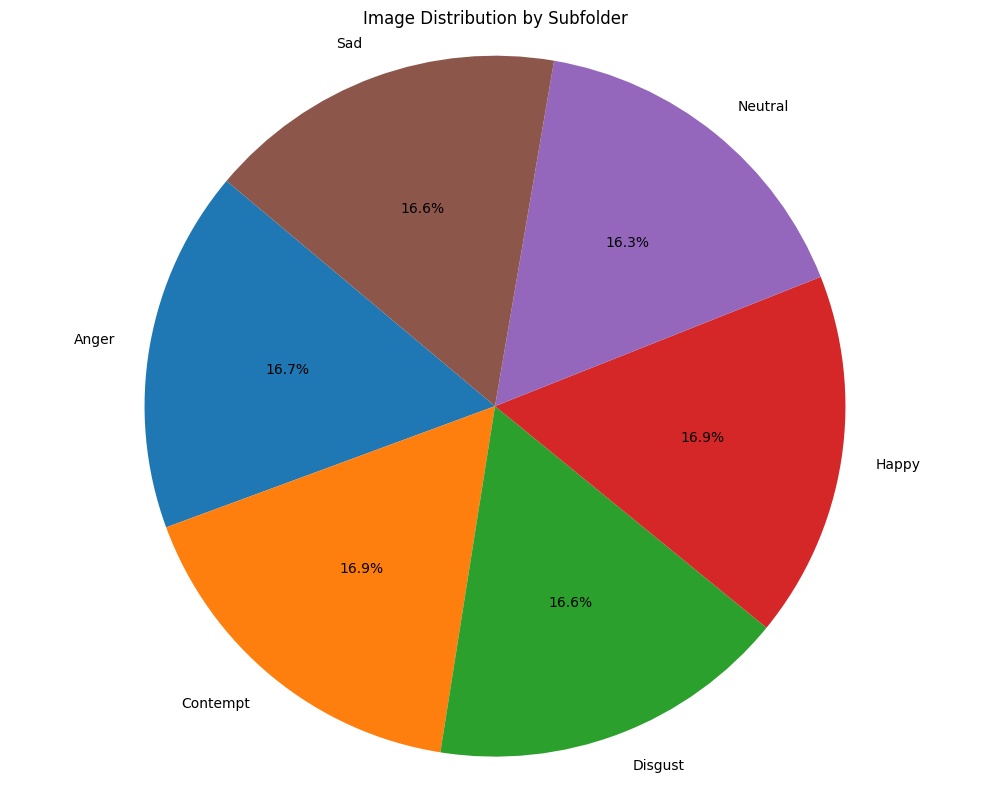

In [26]:
import os# Define the data directory
DATA_DIR = r"D:\ok\data_final\data"  # <-- Update this if needed

# Supported image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

# Dictionary to store count of images per subfolder
image_counts = {}

# Check each subfolder and count image files
if os.path.exists(DATA_DIR):
    for subdir in os.listdir(DATA_DIR):
        full_path = os.path.join(DATA_DIR, subdir)
        if os.path.isdir(full_path):
            count = sum(
                1 for file in os.listdir(full_path)
                if os.path.splitext(file)[1].lower() in image_extensions
            )
            image_counts[subdir] = count
else:
    print(f"Directory does not exist: {DATA_DIR}")

# Prepare data for pie chart
labels = list(image_counts.keys())
sizes = list(image_counts.values())

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.title("Image Distribution by Subfolder")
plt.tight_layout()
plt.show()


### <b><i>Number of images in the Sub-folders

C:\Users\Mukesh\AppData\Local\Temp\ipykernel_14804\3693482330.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotions, y=counts, palette="pastel")


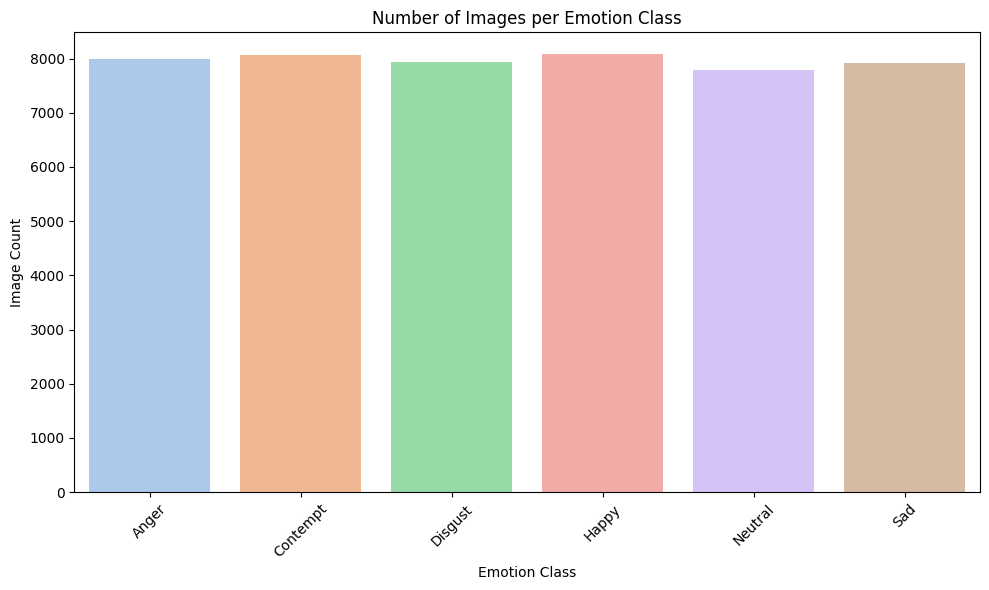

In [27]:

# Define emotion classes (subfolder names)
classes = ['Anger', 'Contempt', 'Disgust', 'Happy', 'Neutral', 'Sad']
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

# Dictionary to store counts
emotion_counts = {}

# Count image files in each subfolder
for emotion in classes:
    folder_path = os.path.join(DATA_DIR, emotion)
    if os.path.isdir(folder_path):
        image_files = [
            f for f in os.listdir(folder_path)
            if os.path.splitext(f)[1].lower() in image_extensions
        ]
        emotion_counts[emotion] = len(image_files)
    else:
        emotion_counts[emotion] = 0  # If folder is missing

# Prepare data
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions, y=counts, palette="pastel")
plt.title("Number of Images per Emotion Class")
plt.xlabel("Emotion Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Valid classes found: 6


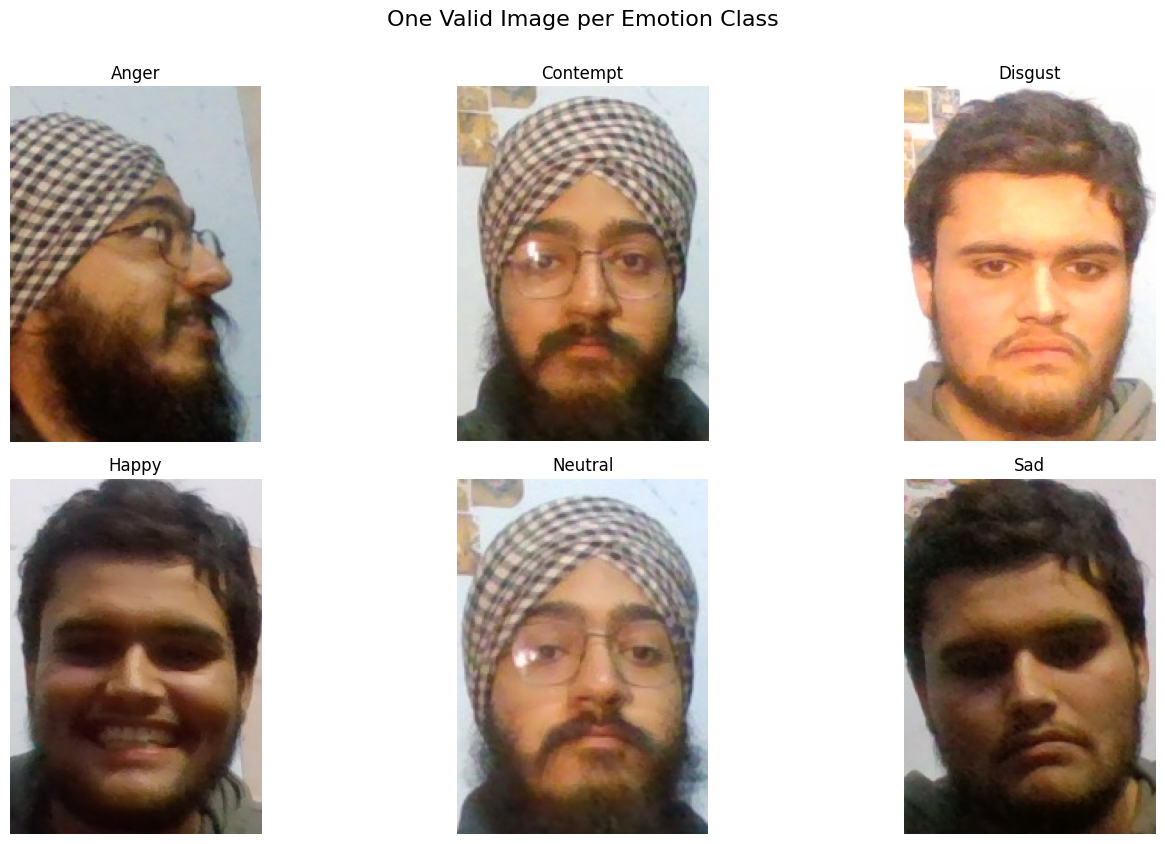

In [44]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define emotion classes
classes = ['Anger', 'Contempt', 'Disgust', 'Happy', 'Neutral', 'Sad']
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

# Set up plot
plt.figure(figsize=(15, 8))
valid_classes = 0

# Loop through each emotion and load one valid image
for i, emotion in enumerate(classes):
    folder_path = os.path.join(DATA_DIR, emotion)
    if os.path.isdir(folder_path):
        found_image = False
        for filename in os.listdir(folder_path):
            if os.path.splitext(filename)[1].lower() in image_extensions:
                img_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(img_path).convert("RGB")
                    plt.subplot(2, 3, valid_classes + 1)
                    plt.imshow(img)
                    plt.title(emotion)
                    plt.axis('off')
                    found_image = True
                    valid_classes += 1
                    break
                except Exception as e:
                    print(f"Skipping invalid image: {img_path} | Reason: {e}")
        if not found_image:
            print(f"No valid image found for class: {emotion}")

print("Valid classes found:", valid_classes)

plt.tight_layout()
plt.suptitle("One Valid Image per Emotion Class", fontsize=16, y=1.05)
plt.show()


### <b><i>Sample Images


### <b><i>Setting the Parameters

In [29]:
# Parameters
height =198
width=282
BATCH_SIZE = 512

EPOCHS = 50
DATA_DIR ="D:\ok\data_final\data"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(height, width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(height, width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 33452 images belonging to 6 classes.
Found 14334 images belonging to 6 classes.


### <b><i>Using Pre-trained Model

In [30]:
# Model: EfficientNetB0
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 198, 282,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 204, 288,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 99, 141,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 99, 141,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 99, 141,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 101, 143,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 71,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 71,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 71,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 71,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 71,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 71,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 71,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 71,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 71,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 71,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 71,    │      1,024 │ conv2_block1_3_c

 Total params: 23,653,478 (90.23 MB)

 Trainable params: 65,766 (256.90 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### <b><i> Training The model

In [31]:
# # Train
# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator)
# # Evaluation
# val_generator.reset()
# Y_pred = model.predict(val_generator)
# y_pred = np.argmax(Y_pred, axis=1)
# print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

# # Save model
# model.save("emotion_model_new.h5")

# # Plot accuracy
# plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()

#### <b><i>Emotion Detection with Photo Capture

In [32]:
# ---------- Emotion Detection with Photo Capture ----------
def detect_emotion(model, frame, img_height, img_width, emotion_labels):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return None, 0.0, None

    (x, y, w, h) = faces[0]
    roi = frame[y:y+h, x:x+w]
    roi = cv2.resize(roi, (img_width, img_height))
    if roi.shape[-1] != 3:
        roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
    roi = roi.astype("float") / 255.0
    roi = np.expand_dims(roi, axis=0)

    preds = model.predict(roi)
    emotion_index = np.argmax(preds)
    confidence = preds[0][emotion_index]
    
    face_img = frame[y:y+h, x:x+w]
    return emotion_labels[emotion_index], confidence, face_img

def run_emotion_detection(model, img_height, img_width, emotion_labels, duration=60):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open camera")
        return None, None, None

    start_time = time.time()
    emotions_detected = []
    confidences = []
    photo_captured = False
    participant_photo = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        emotion, confidence, face_img = detect_emotion(model, frame, img_height, img_width, emotion_labels)
        if emotion is not None:
            emotions_detected.append(emotion)
            confidences.append(confidence)
            if not photo_captured and face_img is not None:
                cv2.imwrite("participant_photo.jpg", face_img)
                participant_photo = face_img
                photo_captured = True
            cv2.putText(frame, f"{emotion} ({confidence:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2)

        cv2.imshow('Emotion Detection - 60 seconds', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        if time.time() - start_time > duration:
            break

    cap.release()
    cv2.destroyAllWindows()
    return emotions_detected, confidences, participant_photo
    


### <b><i>Speech/Text Input

In [33]:
# ---------- Speech/Text Input ----------
def get_voice_input():
    recognizer = sr.Recognizer()
    mic = sr.Microphone()

    print("Please speak your answer after the beep (you have up to 60 seconds to speak)...")
    print("You have 30 seconds to start speaking.")
    with mic as source:
        recognizer.adjust_for_ambient_noise(source)
        print("Start speaking now...")
        try:
            audio = recognizer.listen(source, timeout=30, phrase_time_limit=60)
        except sr.WaitTimeoutError:
            print("No speech detected within 30 seconds. Please try again or type your answer.")
            return input("Type your answer here: ")

    print("\nRecording finished. Processing your speech...")
    try:
        text = recognizer.recognize_google(audio)
        print(f"You said: {text}")
        input("Press Enter to confirm your answer and proceed (or Ctrl+C to re-record): ")
        return text
    except Exception as e:
        print(f"Error during speech recognition: {e}")
        print("Sorry, could not understand your speech. Please type your answer.")
        return input("Type your answer here: ")

def ask_questions(questions):
    answers = []
    selected_questions = random.sample(questions, 5)
    for i, question in enumerate(selected_questions):
        print(f"\nQuestion {i+1}: {question}")
        mode = input("Type 'v' to speak or 't' to type your answer: ").strip().lower()
        if mode == 'v':
            answer = get_voice_input()
            input_mode = 'Voice'
        else:
            answer = input("Type your answer here: ")
            input_mode = 'Text'
        answers.append({'answer': answer, 'mode': input_mode, 'question': question})
    return answers, selected_questions


### <b><i>Sentiment Analysis & Positive Feedback Generator

In [34]:

# ---------- Sentiment Analysis ----------
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive", polarity
    elif polarity < 0:
        return "Negative", polarity
    else:
        return "Neutral", polarity

# ---------- Positive Feedback Generator ----------
def generate_positive_feedback(emotions, sentiments):
    positive_emotions = {'happy', 'surprise'}
    counter = Counter(emotions)
    most_common_emotion = counter.most_common(1)[0][0] if emotions else None
    sentiment_counter = Counter(sentiments)
    positive_sentiment_ratio = sentiment_counter['Positive'] / len(sentiments) if sentiments else 0

    feedback = []
    
    if most_common_emotion in positive_emotions and positive_sentiment_ratio > 0.5:
        feedback.append("Wonderful progress! Your emotional state is remarkably positive, reflecting an excellent outlook.")
        feedback.append("Your responses radiate joy and optimism, which is truly inspiring!")
    elif most_common_emotion in positive_emotions or positive_sentiment_ratio > 0.5:
        feedback.append("Great job! You're showing a fantastic positive demeanor in your emotions and responses.")
        feedback.append("Keep up this encouraging attitude!")
    else:
        feedback.append("You're showing resilience in your emotional journey, which is a promising sign.")
        feedback.append("Your ability to express yourself is a positive step forward!")
    
    return feedback


### <b><i>Summary Generator & Summarization Report

In [40]:
# ---------- Summary Generator ----------
def generate_summary(emotions, sentiments, positive_feedback):
    summary_lines = []
    
    counter = Counter(emotions)
    most_common_emotion = counter.most_common(1)[0] if emotions else None
    if most_common_emotion:
        emotion, count = most_common_emotion
        total = len(emotions)
        percentage = (count / total) * 100
        line = f"The predominant emotion detected was '{emotion}' ({percentage:.2f}% of observations), "
        if emotion in {'happy', 'surprise'}:
            line += "indicating a generally positive emotional state during the assessment."
        elif emotion in {'sad', 'angry', 'disgust', 'fear'}:
            line += "suggesting potential areas of emotional concern that may benefit from further exploration."
        else:
            line += "reflecting a neutral emotional state during the assessment."
        summary_lines.append(line)
    else:
        summary_lines.append("No emotions were detected during the assessment.")

    sentiment_counter = Counter(sentiments)
    total_responses = len(sentiments)
    positive_ratio = sentiment_counter['Positive'] / total_responses if total_responses else 0
    negative_ratio = sentiment_counter['Negative'] / total_responses if total_responses else 0
    summary_lines.append(
        f"Sentiment analysis of responses showed {sentiment_counter['Positive']} positive ({positive_ratio*100:.2f}%), "
        f"{sentiment_counter['Negative']} negative ({negative_ratio*100:.2f}%), and "
        f"{sentiment_counter['Neutral']} neutral responses."
    )
    if positive_ratio > 0.5:
        summary_lines.append("This indicates a predominantly positive outlook in the participant's verbal expressions.")
    elif negative_ratio > 0.5:
        summary_lines.append("This suggests a predominantly negative sentiment, which may warrant further attention.")
    else:
        summary_lines.append("The sentiment appears balanced, reflecting a mix of emotions in the participant's responses.")

    if "wonderful progress" in positive_feedback[0].lower():
        summary_lines.append("Overall, the participant exhibits an excellent state of well-being, with strong positive emotional and verbal indicators.")
    elif "great job" in positive_feedback[0].lower():
        summary_lines.append("Overall, the participant shows promising signs of well-being, with a generally positive emotional and verbal demeanor.")
    else:
        summary_lines.append("Overall, the participant demonstrates resilience and potential for growth, with opportunities for further emotional support.")

    return summary_lines

# ---------- Summarization and Report ----------
def summarize_emotions(emotions, confidences):
    if not emotions:
        return ["No emotions detected."]
    
    counter = Counter(emotions)
    total = len(emotions)
    summary_lines = []
    
    emotion_confidences = {}
    for emotion, confidence in zip(emotions, confidences):
        if emotion not in emotion_confidences:
            emotion_confidences[emotion] = []
        emotion_confidences[emotion].append(confidence)
    
    for emotion, count in counter.items():
        percentage = (count / total) * 100
        avg_confidence = np.mean(emotion_confidences[emotion])
        summary_lines.append(f"{emotion}: {count} occurrences ({percentage:.2f}%) with an average confidence of {avg_confidence:.2f}")
    most_common = counter.most_common(1)[0]
    summary_lines.append(f"Most frequent emotion: {most_common[0]} (count: {most_common[1]})")
    return summary_lines

def generate_emotional_analysis(emotions, confidences):
    counter = Counter(emotions)
    most_common_emotion = counter.most_common(1)[0] if emotions else None
    analysis_lines = []
    analysis_lines.append("The emotion detection results indicate a predominantly ")
    
    if most_common_emotion:
        emotion, count = most_common_emotion
        total = len(emotions)
        percentage = (count / total) * 100
        if emotion in {'happy', 'surprise'}:
            analysis_lines[0] += f"positive emotional state, with {emotion} being the most frequent emotion ({percentage:.2f}% of observations). "
            analysis_lines.append("This suggests that the participant experienced a significant amount of positive affect during the assessment, which may be linked to a stable and optimistic mood.")
        elif emotion in {'sad', 'angry', 'disgust', 'fear'}:
            analysis_lines[0] += f"challenging emotional state, with {emotion} being the most frequent emotion ({percentage:.2f}% of observations). "
            analysis_lines.append("This indicates potential areas of emotional concern that may benefit from further exploration.")
        else:
            analysis_lines[0] += f"neutral emotional state, with {emotion} being the most frequent emotion ({percentage:.2f}% of observations). "
            analysis_lines.append("This reflects a balanced emotional state during the assessment.")
        
        emotion_confidences = {}
        for emotion, confidence in zip(emotions, confidences):
            if emotion not in emotion_confidences:
                emotion_confidences[emotion] = []
            emotion_confidences[emotion].append(confidence)
        avg_confidence = np.mean(emotion_confidences[most_common_emotion[0]])
        analysis_lines.append(f"The high confidence score ({avg_confidence:.2f} for {most_common_emotion[0]}) reflects the reliability of the emotion detection model in identifying this emotional state.")
    
    if len(counter) > 1:
        other_emotions = [f"{emotion} ({(count/total)*100:.2f}%)" for emotion, count in counter.items() if emotion != most_common_emotion[0]]
        analysis_lines.append(f"The presence of other emotions such as {', '.join(other_emotions)} indicates moments of emotional variability.")
        analysis_lines.append("These could be tied to specific triggers or situational factors, which may warrant further exploration in future assessments.")
    else:
        analysis_lines.append("No significant emotional variability was observed during the assessment.")
    
    return analysis_lines

def generate_sentiment_trends(question_answers):
    trends_lines = []
    for i, qa in enumerate(question_answers):
        sentiment, polarity = analyze_sentiment(qa['answer'])
        line = f"Q{i+1} (Polarity: {polarity:.2f}): "
        if polarity > 0:
            line += f"The participant {'starts with a moderately positive sentiment' if i == 0 else 'continues with a positive sentiment'}, reflecting inspiration and ambition."
        elif polarity < 0:
            line += f"A shift to negative sentiment, reflecting {'insecurity' if 'insecure' in qa['answer'].lower() else 'negative emotion'}, though the participant demonstrates proactive coping strategies."
        else:
            line += "A neutral sentiment, indicating a balanced emotional response."
        trends_lines.append(line)
    trends_lines.append("Overall, the sentiment trend shows a generally positive trajectory with a single dip, suggesting emotional resilience despite occasional challenges.")
    return trends_lines

def generate_recommendations(emotions, sentiments, positive_feedback, question_answers):
    counter = Counter(emotions)
    most_common_emotion = counter.most_common(1)[0][0] if emotions else None
    sentiment_counter = Counter(sentiments)
    positive_ratio = sentiment_counter['Positive'] / len(sentiments) if sentiments else 0

    recommendations = []
    
    if positive_ratio > 0.5:
        recommendations.append("Continue Positive Practices: The participant’s frequent positive emotions and optimistic responses suggest that current coping mechanisms (e.g., walking to manage stress, recalling humorous memories) are effective. Continue these practices to maintain emotional well-being.")
    if 'insecure' in ' '.join([qa['answer'].lower() for qa in question_answers]):
        recommendations.append("Address Insecurities: The participant’s mention of insecurity around public speaking could be addressed through targeted skill-building activities, such as joining a public speaking group or practicing with supportive peers.")
    if most_common_emotion in {'sad', 'angry', 'disgust', 'fear'}:
        recommendations.append("Explore Emotional Variability: The presence of sad and angry emotions, though less frequent, indicates potential areas for exploration. Consider journaling or discussing these emotions with a trusted individual to identify triggers and develop coping strategies.")
    recommendations.append("Regular Assessments: Given the participant’s positive outlook, regular emotional assessments can help monitor progress and ensure continued well-being.")
    
    return recommendations

def header(canvas, doc):
    canvas.saveState()
    canvas.setFont("Helvetica-Bold", 12)
    canvas.setFillColor(colors.HexColor('#1a3c6d'))
    canvas.drawString(0.75*inch, A4[1] - 0.5*inch, "MindPlus")
    canvas.setFont("Helvetica", 10)
    canvas.setFillColor(colors.black)
    canvas.drawRightString(A4[0] - 0.75*inch, A4[1] - 0.5*inch, "May 21, 2025")
    canvas.line(0.75*inch, A4[1] - 0.65*inch, A4[0] - 0.75*inch, A4[1] - 0.65*inch)
    canvas.restoreState()

def footer(canvas, doc):
    canvas.saveState()
    canvas.setFont("Helvetica", 9)
    canvas.setFillColor(colors.grey)
    page_number = canvas.getPageNumber()
    canvas.drawString(0.75*inch, 0.5*inch, f"Page {page_number}")
    canvas.drawRightString(A4[0] - 0.75*inch, 0.5*inch, "Generated by Emotion and Sentiment Analysis System")
    canvas.line(0.75*inch, 0.65*inch, A4[0] - 0.75*inch, 0.65*inch)
    canvas.restoreState()

def generate_pdf_report(participant_data, emotion_summary, question_answers, emotions, confidences, selected_questions, participant_photo):
    # Define styles
    styles = getSampleStyleSheet()
    title_style = styles['Heading1']
    title_style.alignment = 1  # Center
    title_style.textColor = colors.HexColor('#1a3c6d')
    title_style.fontSize = 20
    title_style.fontName = 'Helvetica'

    timestamp_style = ParagraphStyle(
        'Timestamp',
        parent=styles['Normal'],
        fontName='Helvetica-Oblique',
        fontSize=10,
        alignment=1,  # Center
        textColor=colors.grey
    )

    section_title_style = ParagraphStyle(
        'SectionTitle',
        parent=styles['Heading2'],
        fontName='Helvetica-Bold',
        fontSize=14,
        textColor=colors.HexColor('#1a3c6d'),
        spaceAfter=12
    )

    normal_style = styles['Normal']
    normal_style.fontSize = 11
    normal_style.leading = 14  # Line spacing
    normal_style.fontName = 'Helvetica'

    list_style = ParagraphStyle(
        'ListItem',
        parent=normal_style,
        leftIndent=20,
        bulletIndent=10,
        spaceAfter=6,
        fontName='Helvetica'
    )

    italic_style = ParagraphStyle(
        'Italic',
        parent=normal_style,
        fontName='Helvetica-Oblique',
        alignment=1  # Center
    )

    # Create the PDF using BaseDocTemplate for more control
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{participant_data['Name']}.pdf"
    
    # Define the frame for the main content (excluding header and footer areas)
    frame = Frame(
        0.75*inch, 1*inch,  # x, y (bottom-left corner)
        A4[0] - 1.5*inch, A4[1] - 2*inch,  # width, height
        leftPadding=0, rightPadding=0, topPadding=0, bottomPadding=0
    )

    # Define PageTemplate with header and footer
    def on_page(canvas, doc):
        header(canvas, doc)
        footer(canvas, doc)

    page_template = PageTemplate(id='AllPages', frames=[frame], onPage=on_page)
    
    # Use BaseDocTemplate instead of SimpleDocTemplate for better control
    doc = BaseDocTemplate(
        filename,
        pagesize=A4,
        topMargin=1*inch,
        bottomMargin=1*inch,
        leftMargin=0.75*inch,
        rightMargin=0.75*inch,
        pageTemplates=[page_template]
    )
    
    story = []

    # Title
    story.append(Paragraph("Emotional Well-Being Assessment Report", title_style))
    story.append(Spacer(1, 12))

    # Timestamp
    timestamp_text = f"Generated on: {datetime.now().strftime('%B %d, %Y, %I:%M %p %Z')}"
    story.append(Paragraph(timestamp_text, timestamp_style))
    story.append(Spacer(1, 24))

    # Participant Information with Photo on the Side
    story.append(Paragraph("Participant Information", section_title_style))
    participant_info_items = []
    for key, value in participant_data.items():
        participant_info_items.append(ListItem(Paragraph(f"<b>{key}:</b> {value}", list_style)))

    info_flowable = ListFlowable(participant_info_items, bulletType='bullet')
    if participant_photo is not None and os.path.exists("participant_photo.jpg"):
        img = Image("participant_photo.jpg")
        img.drawHeight = 1.5*inch
        img.drawWidth = 2*inch
        table_data = [[info_flowable, img]]
    else:
        table_data = [[info_flowable, Paragraph("No photo captured during the session.", italic_style)]]

    table = Table(table_data, colWidths=[A4[0] - 2.5*inch, 2*inch])
    table.setStyle(TableStyle([
        ('VALIGN', (0, 0), (-1, -1), 'TOP'),
        ('ALIGN', (1, 0), (1, 0), 'CENTER'),
        ('LEFTPADDING', (0, 0), (0, 0), 0),
        ('RIGHTPADDING', (1, 0), (1, 0), 0),
    ]))
    story.append(table)
    story.append(Spacer(1, 24))
    # Emotion Detection Summary
    story.append(Paragraph("Emotion Detection Summary", section_title_style))
    story.append(Paragraph("During the 60-second emotion detection session, the following emotions were observed:", normal_style))
    emotion_summary_items = [ListItem(Paragraph(line, list_style)) for line in emotion_summary]
    story.append(ListFlowable(emotion_summary_items, bulletType='bullet'))
    story.append(Spacer(1, 24))

    # Emotional Analysis
    story.append(Paragraph("Emotional Analysis", section_title_style))
    emotional_analysis = generate_emotional_analysis(emotions, confidences)
    for line in emotional_analysis:
        story.append(Paragraph(line, normal_style))
        story.append(Spacer(1, 6))
    story.append(Spacer(1, 24))

    # Questions, Answers, and Sentiment Analysis
    story.append(Paragraph("Questions, Answers, and Sentiment Analysis", section_title_style))
    story.append(Paragraph("The participant was asked 5 randomly selected questions related to their emotional experiences. Below are the questions, their answers, and the corresponding sentiment analysis:", normal_style))
    qa_items = []
    for i, qa in enumerate(question_answers):
        sentiment, polarity = analyze_sentiment(qa['answer'])
        qa_text = f"Q{i+1}: {qa['question']}<br/>Answer ({qa['mode']} input): {qa['answer']}<br/>Sentiment: {sentiment} (Polarity: {polarity:.2f})"
        qa_items.append(ListItem(Paragraph(qa_text, list_style)))
    story.append(ListFlowable(qa_items, bulletType='1'))
    story.append(Spacer(1, 24))

    # Overall Sentiment Summary
    story.append(Paragraph("Overall Sentiment Summary", section_title_style))
    story.append(Paragraph("The sentiment analysis of the participant’s responses revealed the following distribution:", normal_style))
    sentiments = [analyze_sentiment(qa['answer'])[0] for qa in question_answers]
    sentiment_counter = Counter(sentiments)
    positive_ratio = sentiment_counter['Positive'] / len(sentiments) if sentiments else 0
    sentiment_items = []
    for sentiment, count in sentiment_counter.items():
        percentage = (count / len(sentiments)) * 100
        sentiment_items.append(ListItem(Paragraph(f"<b>{sentiment}:</b> {count} responses ({percentage:.2f}%)", list_style)))
    story.append(ListFlowable(sentiment_items, bulletType='bullet'))
    story.append(Paragraph(f"The predominance of positive sentiments ({positive_ratio*100:.2f}%) indicates a generally optimistic outlook in the participant’s verbal expressions, with only a minor instance of negative sentiment related to feelings of insecurity.", normal_style))
    story.append(Spacer(1, 24))

    # Sentiment Trends
    story.append(Paragraph("Sentiment Trends Across Responses", section_title_style))
    story.append(Paragraph("Analyzing the progression of sentiment across the participant’s responses provides insight into their emotional consistency:", normal_style))
    sentiment_trends = generate_sentiment_trends(question_answers)
    trends_items = [ListItem(Paragraph(line, list_style)) for line in sentiment_trends]
    story.append(ListFlowable(trends_items, bulletType='bullet'))
    story.append(Spacer(1, 24))

    # Positive Feedback
    story.append(Paragraph("Positive Feedback", section_title_style))
    positive_feedback = generate_positive_feedback(emotions, sentiments)
    for line in positive_feedback:
        story.append(Paragraph(line, normal_style))
        story.append(Spacer(1, 6))
    story.append(Spacer(1, 24))

    # Recommendations
    story.append(Paragraph("Recommendations", section_title_style))
    story.append(Paragraph("Based on the findings, the following recommendations are suggested:", normal_style))
    recommendations = generate_recommendations(emotions, sentiments, positive_feedback, question_answers)
    rec_items = [ListItem(Paragraph(rec, list_style)) for rec in recommendations]
    story.append(ListFlowable(rec_items, bulletType='bullet'))
    story.append(Spacer(1, 24))
    

    # Summary of Findings
    story.append(Paragraph("Summary of Findings", section_title_style))
    summary = generate_summary(emotions, sentiments, positive_feedback)
    summary_items = [ListItem(Paragraph(line, list_style)) for line in summary]
    story.append(ListFlowable(summary_items, bulletType='bullet'))

    # Build the PDF
    doc.build(story)
    print(f"\nPDF report saved to {filename}.")


### <b><i>Main Function

In [41]:

# ---------- Main Function ----------
def main():
    global model, img_height, img_width, emotion_labels
    # Load model
    model_path = "D:/ok/trained.h5"
    img_height, img_width = 323, 228
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

    try:
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Get participant info first (including medical history)
    participant_data = {
        "Name": input("Enter your name: "),
        "Age": input("Enter your age: "),
        "Gender": input("Enter your gender: "),
        "Date of Birth": input("Enter your date of birth (YYYY-MM-DD): "),
        "Medical History": input("Enter your medical history: "),
        "Date of Assessment": datetime.now().strftime("%Y-%m-%d")    
        }

    # Start emotion detection after participant info input is done
    print("\nStarting real-time emotion detection for 60 seconds...")
    emotions, confidences, participant_photo = run_emotion_detection(model, img_height, img_width, emotion_labels, duration=60)
    emotion_summary = summarize_emotions(emotions, confidences)


###################### Question Pool #######################
    
    emotion_questions = [
        "Can you describe a recent moment when you felt overwhelmingly happy and what caused it?",
        "What do you do when you feel sad to help lift your spirits?",
        "How do you typically react when you feel angry, and can you share a recent example?",
        "What is one thing that consistently makes you feel anxious, and how do you cope with it?",
        "Can you recall a time when you felt deeply disappointed? How did you handle it?",
        "What does joy feel like for you, and when did you last experience it?",
        "How do you manage stress when you’re feeling overwhelmed?",
        "What’s a memory that always makes you feel nostalgic, and why?",
        "How do you express gratitude in your daily life, and who do you feel most grateful for?",
        "Can you describe a time when you felt proud of yourself and what led to that moment?",
        "What makes you feel most at peace, and how often do you experience that feeling?",
        "How do you deal with feelings of loneliness, and can you share a recent experience?",
        "What’s something that frustrates you regularly, and how do you address it?",
        "Can you describe a time when you felt truly inspired? What sparked that inspiration?",
        "How do you feel when you’re around your closest friends or family, and why?",
        "What’s a fear you’ve overcome in the past, and how did you do it?",
        "How do you express love to the people you care about, and can you give an example?",
        "What does sadness look like for you, and how do you work through it?",
        "Can you share a moment when you felt embarrassed? How did you recover from it?",
        "What’s something that excites you about the future, and why does it make you feel that way?",
        "How do you handle feelings of jealousy, and can you share an instance when you felt this way?",
        "What’s a memory that makes you feel safe and secure, and why does it have that effect?",
        "How do you feel when you accomplish a challenging task, and can you give an example?",
        "What’s something that makes you feel angry, and how do you calm yourself down?",
        "Can you describe a time when you felt completely relaxed? What contributed to that feeling?",
        "How do you react when someone close to you is upset, and can you share an example?",
        "What’s a situation that made you feel guilty, and how did you resolve those feelings?",
        "How do you feel when you’re in a new or unfamiliar environment, and why?",
        "What’s something that brings you comfort during tough times, and how does it help?",
        "Can you describe a time when you felt a deep sense of loss? How did you cope with it?",
        "What makes you feel hopeful, and can you share a recent moment of hope?",
        "How do you manage feelings of frustration when things don’t go as planned?",
        "What’s a memory that makes you laugh every time you think about it, and why is it so funny?",
        "How do you feel when you receive criticism, and how do you typically respond?",
        "What’s something that makes you feel loved, and can you share a recent experience?",
        "Can you describe a time when you felt betrayed? How did you move forward from it?",
        "What’s a situation that makes you feel nervous, and how do you prepare for it?",
        "How do you celebrate your successes, and can you share a recent celebration?",
        "What’s something that makes you feel insecure, and how do you work through those feelings?",
        "Can you describe a time when you felt a strong sense of belonging? What created that feeling?",
        "How do you feel when you help someone else, and can you share a recent example?",
        "What’s something that makes you feel disappointed, and how do you handle it?",
        "Can you describe a time when you felt deeply connected to someone? What happened?",
        "What’s a situation that makes you feel overwhelmed, and how do you manage it?",
        "How do you feel when you reflect on your past achievements, and why?",
        "What’s something that makes you feel calm, and how often do you seek that feeling?",
        "Can you describe a time when you felt rejected? How did you deal with that experience?",
        "What’s a memory that makes you feel proud of someone else, and why?",
        "How do you feel when you’re faced with a difficult decision, and can you share an example?",
        "What’s something that makes you feel optimistic about life, and why?",
        "Can you describe a time when you felt truly understood by someone? What made that moment special?"
    ]

    print("\nNow, you will answer 5 randomly selected questions about your emotions. You can choose to speak or type each answer.")
    answers, selected_questions = ask_questions(emotion_questions)

    # Generate the PDF report
    generate_pdf_report(participant_data, emotion_summary, answers, emotions, confidences, selected_questions, participant_photo)

if __name__ == "__main__":
    main()

Model loaded successfully.

Starting real-time emotion detection for 60 seconds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 

# <b>                                                       Thank you